<div align='center'>
    <h1>EL26: Analogue and Digital Filtering</h1>
    <h2>Digital Section</h2>
</div>

**Name:** Jack Barker and Thomas Marsden **Date:** 28/02/2023, **Time:** 10:11

<hr/>

## Instructions

1. Read through the digital section of the EL26 labscript.
2. Complete each section of this notebook as you go along. (Gaps in the code
    are often marked `################` for you to fill in.)
3. When you're finished, print a copy of your completed notebook and attach it
    to your logbook. **Please print two-to-a-page and double-sided to save
    paper.**

**Important:** *If you experience unusual outputs, before speaking to a
demonstrator try 'Restart Kernel and Run All Cells', instead of just running
cells individually. This will ensure all variables are correctly propagated.
When writing Jupyter notebooks yourself in the future, or when adding to the
code below, avoiding reusing variable names can help get around this issue.*

<hr/>

## Section 1: Loading the Raw Signal

### Importing the Required Libraries

In [187]:
# Import NumPy and Pandas for data manipulation
import numpy as np
import pandas as pd

# Import SciPy signal-processing library
import scipy.signal as signal

# Import matplotlib and IPython display for plotting and generating audio clips
import matplotlib.pyplot as plt
import IPython.display as display

### Reading the CSV

**Note:** You may need to change the CSV file path depending on where the data
are stored, and what the file is called.

In [188]:
# Load raw signal from CSV into a Pandas dataframe
raw = pd.read_csv('EL26_digital_raw.csv')

# Preview first few entries
raw.head()

,t,V
0,0.000000,0.295365
1,0.000023,0.251039
2,0.000045,0.134088
3,0.000068,1.040580
4,0.000091,0.573271


### Plotting the Data

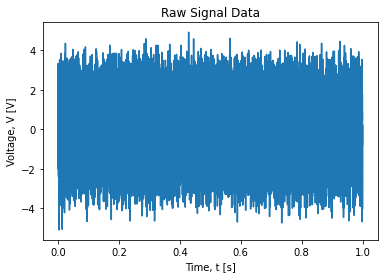

In [189]:
# Plot data as time-series
plt.plot(raw['t'], raw['V'])

# Label axes
plt.xlabel('Time, t [s]')
plt.ylabel('Voltage, V [V]')

# Label plot
plt.title('Raw Signal Data')

# Show plot
plt.show()

### Plotting the Data: Zoomed

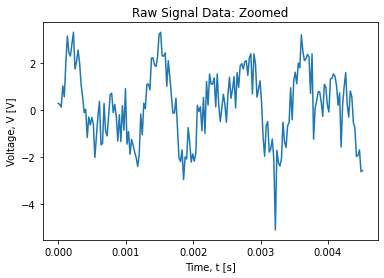

In [190]:
# Using Python's slices, we can select the first N samples with the notation
# [:N] after a list-like variable. If we wanted N samples starting at k, we
# would write [k:k+N]. If we wanted all but the first N samples, we would write
# [N:]. Here, we select the first 200 samples and plot the data as a
# time-series.
plt.plot(raw['t'][:200], raw['V'][:200])

# Label axes
plt.xlabel('Time, t [s]')
plt.ylabel('Voltage, V [V]')

# Label plot
plt.title('Raw Signal Data: Zoomed')

# Show plot
plt.show()

### Listening to the Raw Signal

**Note:** The signal was sampled at a rate of $44.1\,\mathrm{kHz}$; as if we
were recording it to a CD.

In [191]:
# Define the sampling rate, fs (this will also be useful later)
fs = 44.1e3

# Using the IPython display module (built into Jupyter) we can listen to any
# NumPy array, provided we give the desired sampling rate (to ensure correct
# playback speed).
display.Audio(raw['V'], rate=fs)

<hr/>

## Section 2: Transforming to the Frequency Domain

### Transforming the Data

In [192]:
# Plot the magnitude of the frequency spectrum against the frequency. 
# Remember the Fourier transform results in a complex output, when plotting we
# will take the magnitude (you can use np.max()).
f = raw['t']*fs


# NumPy provides an FFT function (np.fft.fft). Transform the voltage array to
# a frequency spectrum, then run the following cell to plot it and check it
# makes sense.
freq_spectrum = np.fft.fft(raw['V'])

### Plotting the Frequency Spectrum

44100
44100


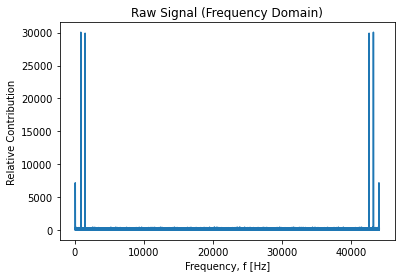

In [193]:
# Plot the magnitude of the frequency spectrum against the frequency. 
# Remember the Fourier transform results in a complex output, when plotting we
# will take the magnitude (you can use np.abs()).

plt.plot(f, np.abs(freq_spectrum))

print(len(f))
print(len(np.abs(freq_spectrum)))
# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title('Raw Signal (Frequency Domain)')

# Show plot
plt.show()

### Plotting the Frequency Spectrum: Zoomed

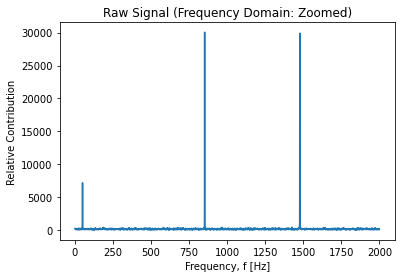

In [194]:
# Like in the first section, plot a subset of the frequency spectrum, zooming
# in on the three important peaks.
plt.plot(f[:2000], np.abs(freq_spectrum)[:2000])

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title('Raw Signal (Frequency Domain: Zoomed)')

# Show plot
plt.show()

### Finding Peaks

In [195]:
# SciPy's signal-processing capabilities can automatically detect peaks in an
# array of data. Try varying the height threshold parameter below to select
# just the important peaks, and not the wide-band noise.
peaks, heights = signal.find_peaks(np.abs(freq_spectrum), height=5000)

# Convert peak indices from freq_spectrum to frequencies and print
print(f'Found {len(peaks)} peaks:')
_ = [print(f'{f[peak]:.3f} Hz') for peak in peaks]

Found 6 peaks:
50.001 Hz
852.019 Hz
1477.033 Hz
42623.967 Hz
43248.981 Hz
44050.999 Hz


There are 6 peaks in total, but we're only interested in the first 3, since the other 3 are above the nyquist frequency.

If all the DTMF digits were encoded for, we'd expect 8 peaks, corresponding to the 8 different DTMF frequencies.

The main frequency components are 50 Hz, 852 Hz and 1477 Hz.

The 852 Hz and 1477 Hz peaks correspond to the the DTMF digit 9.

The 50 Hz peak is likely AC noise, since the UK AC frequency is 50 Hz.

<hr/>

## Section 3: A Frequency-Domain Low-Pass Filter

### Creating the Filter

In [196]:
# Choose a cutoff frequency
lowpass_freq_fc = 1000

# Create an array with the same shape as freq_spectrum above, and fill it with
# zeroes to cut-out all frequencies.
lowpass_freq = np.zeros(freq_spectrum.shape)

# Find the index of the largest frequency below the chosen cutoff frequency
lowpass_freq_fc_index = np.where(f < lowpass_freq_fc)[0].max()

# Set the first elements, up until the index corresponding to the cutoff
# frequency, to one, to allow low-frequencies through.
lowpass_freq[:lowpass_freq_fc_index + 1] = 1

# It's good practice to make our filters symmetric about the Nyquist frequency,
# so allow the absolute highest frequencies through (remember supplying a
# negative index in Python is equivalent to counting backwards)
lowpass_freq[-lowpass_freq_fc_index:] = 1

# Note: we could have combined the last two lines into one if we initially
# started with an array of ones and cut out the central section.
#
# lowpass_freq = np.ones(freq_spectrum.shape)
# lowpass_freq[lowpass_freq_fc_index:-lowpass_freq_fc_index + 1] = 0

# Apply filter through multiplication with the original frequency spectrum
lowpass_freq_spectrum = freq_spectrum * lowpass_freq

### Plotting the Filter Response

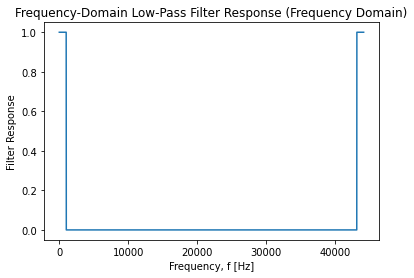

In [197]:
# Plot how the filter affects different frequencies
plt.plot(f, lowpass_freq)

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Filter Response')

# Label plot
plt.title('Frequency-Domain Low-Pass Filter Response (Frequency Domain)')

# Show plot
plt.show()

### Plotting the Filtered Frequency Spectrum

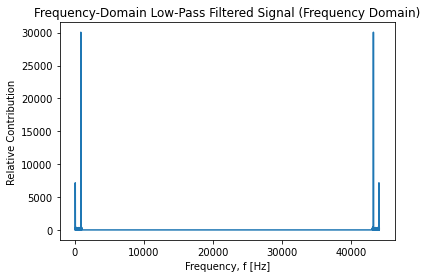

In [198]:
# Plot the filtered frequency spectrum (again, just the magnitude using np.abs)
plt.plot(f, np.abs(lowpass_freq_spectrum))

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title('Frequency-Domain Low-Pass Filtered Signal (Frequency Domain)')

# Show plot
plt.show()

### Plotting the Filtered Frequency Spectrum: Zoomed

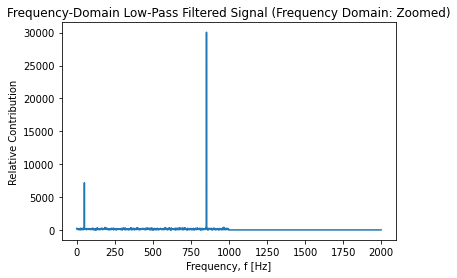

In [199]:
# Plot the same subset of the frequency spectrum as before filtering for good
# comparison.
plt.plot(f[:2000], np.abs(lowpass_freq_spectrum)[:2000])

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title(
    'Frequency-Domain Low-Pass Filtered Signal (Frequency Domain: Zoomed)'
)

# Show plot
plt.show()

### Transforming Back to the Time Domain

In [200]:
# NumPy provides an inverse FFT function (np.fft.ifft). Use it to transform
# your filtered signal back into the time domain. We will discard the imaginary
# components here too (wrap the inverse FFT function in np.real).
lowpass_freq_V = np.real(np.fft.ifft(lowpass_freq_spectrum))
# Note that it's good practice to use fft/ifft, because there are
# normalizations involved, for which there is no general standard, and by
# using this pair of functions you make sure that these are consistent

### Plotting the Filtered Signal: Zoomed

**Note:** There is no need to plot the full filtered signal, as we know it
won't show the required level of detail we need to see the effects of our
filter. Hence we skip straight to the zoomed plot.

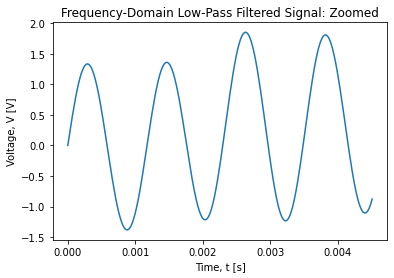

In [201]:
# Plot the same subset of the filtered data as in the first section when we
# viewed a zoomed section of the raw signal.
plt.plot(raw['t'][:200], lowpass_freq_V[:200])

# Label axes
plt.xlabel('Time, t [s]')
plt.ylabel('Voltage, V [V]')

# Label plot
plt.title('Frequency-Domain Low-Pass Filtered Signal: Zoomed')

# Show plot
plt.show()

### Listening to the Filtered Signal

In [202]:
display.Audio(lowpass_freq_V, rate=fs)

We can hear that the filter has massively reduced the noise in the signal, and so we only really hear a pure tone (this is reflected in the inverse Fourier transfom plot above). Since we have removed all frequencies above 1kHz, we can only hear the 852 Hz tone, rather than the combination of this with the 1477 Hz tone.

<hr/>

## Section 4: A Frequency-Domain High-Pass Filter

### Creating the Filter

In [203]:
# Choose a cutoff frequency
highpass_freq_fc = 1400

# Create an array with the same shape as freq_spectrum above, and fill it with
# zeroes to cut-out all frequencies.
highpass_freq = np.zeros(freq_spectrum.shape)

# Find the index of the smallest frequency above the chosen cutoff frequency
highpass_freq_fc_index = np.where(f>highpass_freq_fc)[0].min()

# Set the end elements, up until the index corresponding to the cutoff
# frequency, to one, to allow high-frequencies through.
highpass_freq[highpass_freq_fc_index:] = 1

# Remove the low-frequency components reflected above the Nyquist frequency.
# Remember that supplying a negative index in Python is equivalent to counting
# backwards.
highpass_freq[-highpass_freq_fc_index:] = 0

# Note: we could have achieved the above two lines of code in just one (with a
# sligh discrepancy in the upper bound index):
# highpass_freq[highpass_freq_fc_index:-highpass_freq_fc_index + 1] = 1

# Apply filter through multiplication with the original frequency spectrum
highpass_freq_spectrum = freq_spectrum*highpass_freq

### Plotting the Filter Response

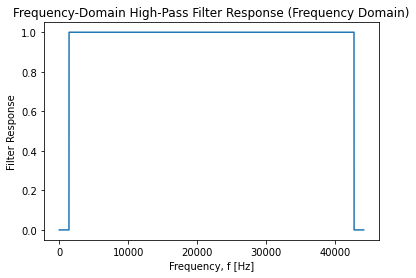

In [204]:
# Plot how the filter affects different frequencies
plt.plot(f, highpass_freq)

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Filter Response')

# Label plot
plt.title('Frequency-Domain High-Pass Filter Response (Frequency Domain)')

# Show plot
plt.show()

### Plotting the Filtered Frequency Spectrum

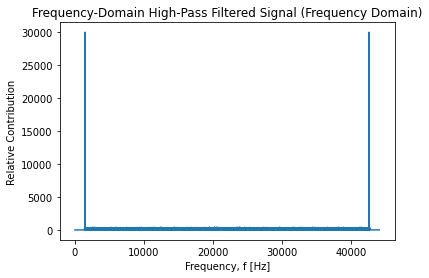

In [205]:
# Plot the filtered frequency spectrum (again, just the magnitude using np.abs)
plt.plot(f, np.abs(highpass_freq_spectrum))

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title('Frequency-Domain High-Pass Filtered Signal (Frequency Domain)')

# Show plot
plt.show()

### Plotting the Filtered Frequency Spectrum: Zoomed

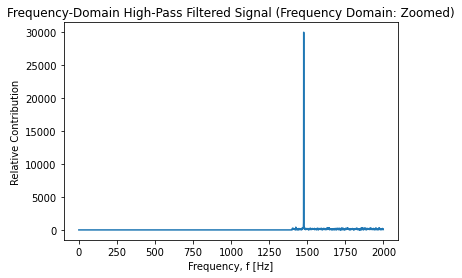

In [206]:
# Plot the same subset of the frequency spectrum as before filtering for good
# comparison.
plt.plot(f[:2000], np.abs(highpass_freq_spectrum)[:2000])

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title(
    'Frequency-Domain High-Pass Filtered Signal (Frequency Domain: Zoomed)'
)

# Show plot
plt.show()

### Transforming Back to the Time Domain

In [207]:
# Transform back to the time domain, again discarding imaginary components.
highpass_freq_V = np.real(np.fft.ifft(highpass_freq_spectrum))

### Plotting the Filtered Signal: Zoomed

**Note:** Again, there is no need to plot the full filtered signal, as we know
it won't show the required level of detail we need to see the effects of our
filter. Hence we skip straight to the zoomed plot.

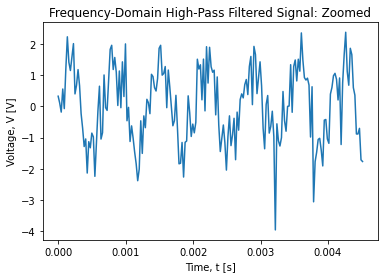

In [208]:
# Plot the same subset of the filtered data as in the first section when we
# viewed a zoomed section of the raw signal.
plt.plot(raw['t'][:200], highpass_freq_V[:200])

# Label axes
plt.xlabel('Time, t [s]')
plt.ylabel('Voltage, V [V]')

# Label plot
plt.title('Frequency-Domain High-Pass Filtered Signal: Zoomed')

# Show plot
plt.show()

### Listening to the Filtered Signal

In [209]:
display.Audio(highpass_freq_V, rate=fs)

The highpass filter has removed the 50 Hz noise, but has also removed the 852 Hz tone, since this is below the cutoff frequency of 1.4kHz. We can only hear the 1477 Hz tone. We also hear a lot of noise, since we have removed all frequencies below 1kHz, and so we are left with a lot of noise.

<hr/>

## Section 5: A Frequency-Domain Band-Pass Filter

### Creating the Filter

In [210]:
# Choose a lower and upper cutoff frequency to isolate just the lower of the
# DTMF pair
bandpass_freq_fc_low = 800
bandpass_freq_fc_upp = 900

# Create an array with the same shape as freq_spectrum above, and fill it with
# zeroes to cut-out all frequencies.
bandpass_freq = np.zeros(freq_spectrum.shape)

# Find the index of the largest frequency below the chosen cutoff frequency
bandpass_freq_fc_low_index = np.where(f < bandpass_freq_fc_low)[0].max()

# Find the index of the smallest frequency above the chosen cutoff frequency
bandpass_freq_fc_upp_index = np.where(f > bandpass_freq_fc_upp)[0].min()

# Set the end elements, up until the index corresponding to the cutoff
# frequency, to one, to allow high-frequencies through.
bandpass_freq[bandpass_freq_fc_low_index:bandpass_freq_fc_upp_index + 1] = 1

# Ensure symmetry about the Nyquist frequency
bandpass_freq[-bandpass_freq_fc_upp_index:-bandpass_freq_fc_low_index + 1] = 1

# Apply filter through multiplication with the original frequency spectrum
bandpass_freq_spectrum = freq_spectrum * bandpass_freq

### Plotting the Filter Response

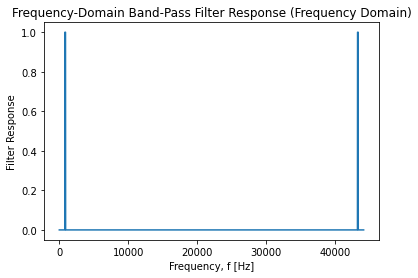

In [211]:
# Plot how the filter affects different frequencies
plt.plot(f, bandpass_freq)

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Filter Response')

# Label plot
plt.title('Frequency-Domain Band-Pass Filter Response (Frequency Domain)')

# Show plot
plt.show()

### Plotting the Filtered Frequency Spectrum

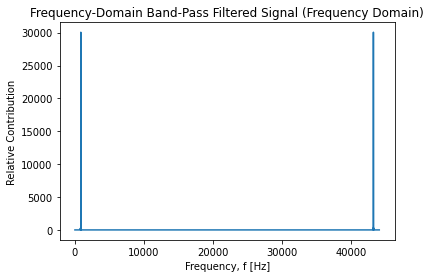

In [212]:
# Plot the filtered frequency spectrum (again, just the magnitude using np.abs)
plt.plot(f, np.abs(bandpass_freq_spectrum))

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title('Frequency-Domain Band-Pass Filtered Signal (Frequency Domain)')

# Show plot
plt.show()

### Plotting the Filtered Frequency Spectrum: Zoomed

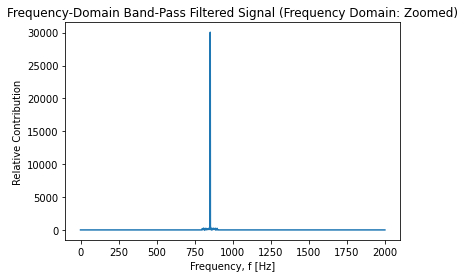

In [213]:
# Plot the same subset of the frequency spectrum as before filtering for good
# comparison.
plt.plot(f[:2000], np.abs(bandpass_freq_spectrum)[:2000])

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title(
    'Frequency-Domain Band-Pass Filtered Signal (Frequency Domain: Zoomed)'
)

# Show plot
plt.show()

### Transforming Back to the Time Domain

In [214]:
# Transform back to the time domain, again discarding imaginary components.
bandpass_freq_V = np.real(np.fft.ifft(bandpass_freq_spectrum))

### Plotting the Filtered Signal: Zoomed

**Note:** Again, there is no need to plot the full filtered signal, as we know
it won't show the required level of detail we need to see the effects of our
filter. Hence we skip straight to the zoomed plot.

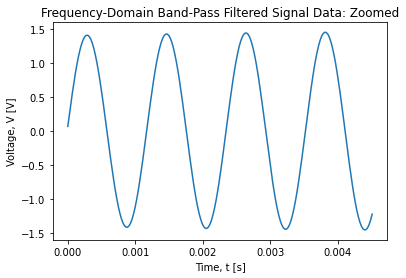

In [215]:
# Plot the same subset of the filtered data as in the first section when we
# viewed a zoomed section of the raw signal.
plt.plot(raw['t'][:200], bandpass_freq_V[:200])

# Label axes
plt.xlabel('Time, t [s]')
plt.ylabel('Voltage, V [V]')

# Label plot
plt.title('Frequency-Domain Band-Pass Filtered Signal Data: Zoomed')

# Show plot
plt.show()

### Listening to the Filtered Signal

In [216]:
display.Audio(bandpass_freq_V, rate=fs)

The effect of the filter is easy to hear. The 50 Hz noise has been removed, as well as most other noise in the frequency spectrum. Additionally, the 1477 Hz component has been removed, so we basically only hear the pure 852 Hz sine wave.

<hr/>

**Time:** 11:09

<hr/>

## Section 6: Moving average filter

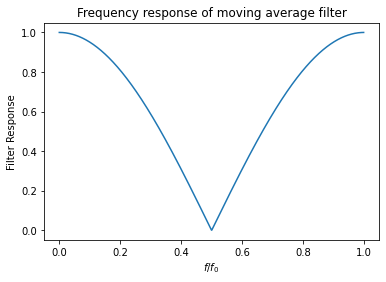

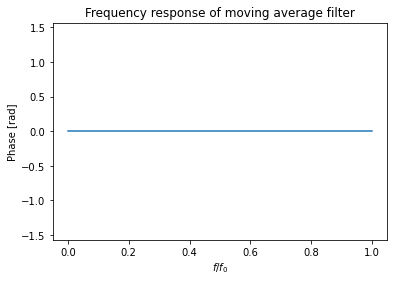

In [217]:
# Initialize an array for the impulse response
ma_ir = [0]*1001
# and fill the impulse response (to allow for positive and negative times we start the impulse at n = 500)
ma_ir[499] = 0.
ma_ir[500] = 0.5
ma_ir[501] = 0.5
ma_ir[502] = 0.
# Now find the filter response function in the frequency domain from FFT
ma_spectrum = np.fft.fft(ma_ir)

# and plot
freq = np.arange(0,1.001,0.001)
plt.plot(freq,abs(ma_spectrum))
# Label axes
plt.xlabel(r'$f/f_{0}$')
plt.ylabel('Filter Response')
# Label plot
plt.title('Frequency response of moving average filter')
# Show plot
plt.show()

# is there a phase introduced by the filter (you can use the np.angle() function)?
phase = np.angle(ma_spectrum)
# shift phase so that output is only in the range -pi/2 to pi/2 (why?)
for i,x in enumerate(phase):
    if x > np.pi/2:
        phase[i] = x - np.pi
    elif x < -np.pi/2:
        phase[i] = x + np.pi

# plot phase 
plt.plot(freq,phase)
plt.ylim([-np.pi/2,np.pi/2])
# Label axes
plt.xlabel(r'$f/f_{0}$')
plt.ylabel('Phase [rad]')
# Label plot
plt.title('Frequency response of moving average filter')
# Show plot
plt.show()

This frequency response looks as expected. The moving average filter leaves low frequency signals relatvely unaffected, while high frequency signals will be reduced. Since it's a digital filter, we also expect a reflection about the Nyquist frequency. This is what we observe; the response is close to 1 for low frequencies, and falls to 0 at $f=f_0/2$ (the Nyquist frequency). It then increases again, as a mirror image of the response below the Nyquist frequency.

For unity response at $f/f_0=0$, the sum of the values must be 1.

For no phase shift, the filter must be symmetrical about $t=0$ (the centre in the time domain).

### Sharpening the filter response

We now aim to sharpen the filter response. This can be achieved by spreading out the filter:

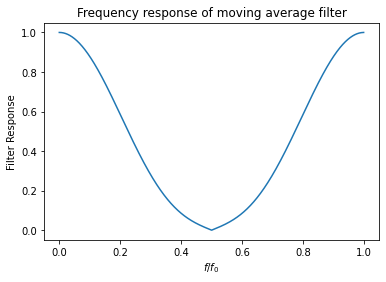

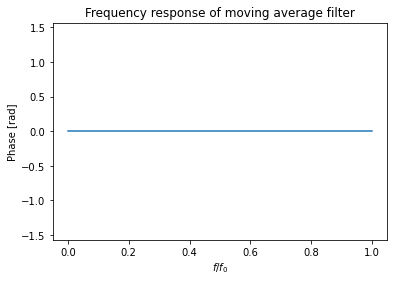

In [218]:
# Initialize an array for the impulse response
ma_ir = [0]*1001
# and fill the impulse response (to allow for positive and negative times we start the impulse at n = 500)
ma_ir[499] = 0.1
ma_ir[500] = 0.4
ma_ir[501] = 0.4
ma_ir[502] = 0.1
# Now find the filter response function in the frequency domain from FFT
ma_spectrum = np.fft.fft(ma_ir)

# and plot
freq = np.arange(0,1.001,0.001)
plt.plot(freq,abs(ma_spectrum))
# Label axes
plt.xlabel(r'$f/f_{0}$')
plt.ylabel('Filter Response')
# Label plot
plt.title('Frequency response of moving average filter')
# Show plot
plt.show()

# is there a phase introduced by the filter (you can use the np.angle() function)?
phase = np.angle(ma_spectrum)
# shift phase so that output is only in the range -pi/2 to pi/2 (why?)
for i,x in enumerate(phase):
    if x > np.pi/2:
        phase[i] = x - np.pi
    elif x < -np.pi/2:
        phase[i] = x + np.pi

# plot phase 
plt.plot(freq,phase)
plt.ylim([-np.pi/2,np.pi/2])
# Label axes
plt.xlabel(r'$f/f_{0}$')
plt.ylabel('Phase [rad]')
# Label plot
plt.title('Frequency response of moving average filter')
# Show plot
plt.show()

However, if we increase the spread too much, we get oscillations where we'd like the filter to supress

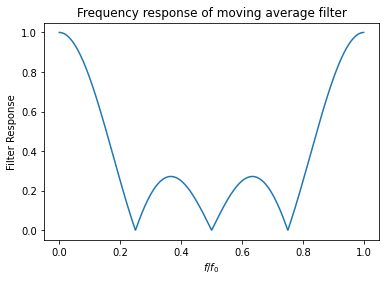

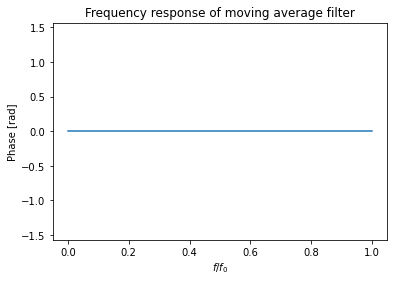

In [219]:
# Initialize an array for the impulse response
ma_ir = [0]*1001
# and fill the impulse response (to allow for positive and negative times we start the impulse at n = 500)
ma_ir[499] = 0.25
ma_ir[500] = 0.25
ma_ir[501] = 0.25
ma_ir[502] = 0.25
# Now find the filter response function in the frequency domain from FFT
ma_spectrum = np.fft.fft(ma_ir)

# and plot
freq = np.arange(0,1.001,0.001)
plt.plot(freq,abs(ma_spectrum))
# Label axes
plt.xlabel(r'$f/f_{0}$')
plt.ylabel('Filter Response')
# Label plot
plt.title('Frequency response of moving average filter')
# Show plot
plt.show()

# is there a phase introduced by the filter (you can use the np.angle() function)?
phase = np.angle(ma_spectrum)
# shift phase so that output is only in the range -pi/2 to pi/2 (why?)
for i,x in enumerate(phase):
    if x > np.pi/2:
        phase[i] = x - np.pi
    elif x < -np.pi/2:
        phase[i] = x + np.pi

# plot phase 
plt.plot(freq,phase)
plt.ylim([-np.pi/2,np.pi/2])
# Label axes
plt.xlabel(r'$f/f_{0}$')
plt.ylabel('Phase [rad]')
# Label plot
plt.title('Frequency response of moving average filter')
# Show plot
plt.show()

### Applying the filter to data

We would now like to see the response of data to this filter. To do this, we set up a filter, and convolve it with the data

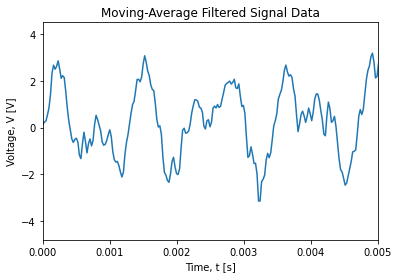

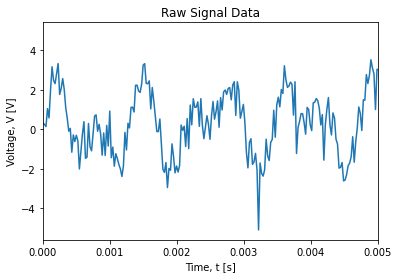

In [220]:
# set up the impule response moving average filter
ma_ir = [0.1, 0.4, 0.4, 0.1]

# perform the convolution of the raw data with the impulse response
# the mode="same" parameter ensures that the output is the same length as the input
filtered = np.convolve(raw["V"], ma_ir, mode="same")

plt.plot(raw["t"], filtered)
plt.xlim([0,0.005])
plt.xlabel("Time, t [s]")
plt.ylabel("Voltage, V [V]")
plt.title("Moving-Average Filtered Signal Data")
plt.show()


plt.plot(raw["t"], raw["V"])
plt.xlim([0,0.005])
plt.xlabel("Time, t [s]")
plt.ylabel("Voltage, V [V]")
plt.title("Raw Signal Data")
plt.show()

It is clear to see that the high frequency components have been partially removed.

<hr/>

## Section 7: FIR Filter impulse response length
$H_n = 2\frac{f_\mathrm{c}}{f_\mathrm{s}}\mathrm{sinc}
    \left(2\frac{f_\mathrm{c}}{f_\mathrm{s}}n\right)$

For 21 samples:

In [221]:
def sinc_filter(FIRn):
    """Create a sinc filter with FIRn samples in the impulse response
    Returns Hn at the end, so we can use this function for Hamming window"""

    # sampling frequency
    fs = 44100
    # cut-off frequency
    fc = 1000
    # create a perfect filter (symmetric impulse response)
    n = np.arange(len(raw['t'])+1)
    n_centred = n - n.max() / 2
    Hn = 2*fc/fs*np.sinc(2*fc/fs*n_centred)

    # square window function - first set whole window to zero
    square = [0]*len(Hn)
    # now fill non-zero values of the window (startindex is where the non-zero part of the window starts)
    startindex = int((len(Hn)-1)/2-(FIRn-1)/2)
    for i in range(0,FIRn): 
        square[startindex+i] = Hn[startindex+i]

    # use window function on impulse respone
    FIRtwindowed = Hn*square

    # plot windowed filter function
    plt.step(n,FIRtwindowed)
    plt.xlim([startindex-FIRn/2,startindex+1.5*FIRn])
    # Show plot
    plt.show()

    # Now find the filter response function in the frequency domain from FFT
    FIRf = np.fft.fft(FIRtwindowed)
    # and plot
    freq = np.arange(0,fs,fs/(len(raw['t'])+1))
    plt.plot(freq,abs(FIRf))
    # Label axes
    plt.xlabel('f [Hz]')
    plt.ylabel('Filter Response')
    # Label plot
    plt.title('Frequency response of FIR filter')
    # Show plot
    plt.show()
    return Hn

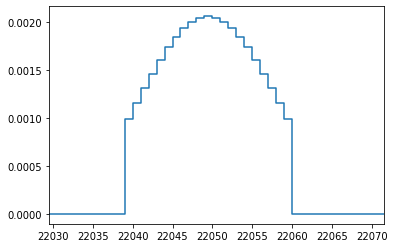

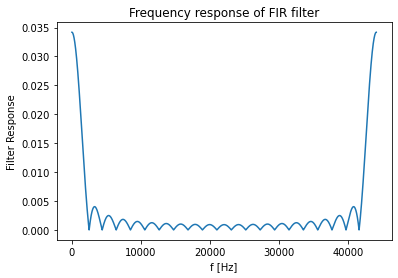

In [222]:
Hn_21=sinc_filter(21)

And for 101 samples:

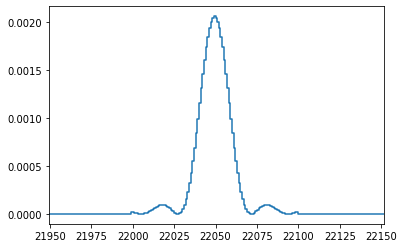

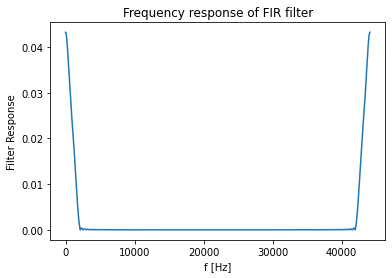

In [223]:
Hn_101=sinc_filter(101)

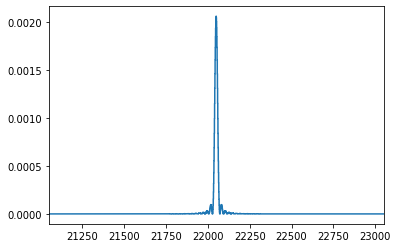

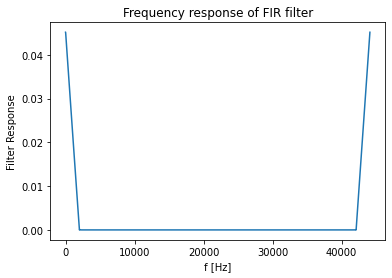

In [224]:
Hn_1001=sinc_filter(1001)

When you truncate the sinc eariler, we get oscillations within the cutoff region in the frequency domain, leading to a less ideal response. By increaseing the number of sample points in the sinc, we get a better filter, with sharper cutoff and better damping in the cut-off range.

### Hamming window

$w(t)=0.54-0.46\cos\left(\frac{2\pi t}{N-1}\right)$

In [231]:
def hamming_filter(Hn, FIRn):
    """
    Plot the Hamming windowed filter impulse response
    """
    # Hamming window function - first set whole window to zero
    hamming = [0]*len(Hn)

    n=np.arange(len(raw['t'])+1)
    # now fill non-zero values of the window (startindex is where the non-zero part of the window starts)
    startindex = int((len(Hn)-1)/2-(FIRn-1)/2)
    for i in range(0,FIRn): 
        hamming[startindex+i] = 0.54-0.46*np.cos(2*np.pi*i/(FIRn-1))

    # use windowing function to truncate the filter impulse response
    FIRtwindowed = Hn*hamming

    # plot windowed filter function
    plt.step(n,FIRtwindowed)
    plt.xlim([startindex-FIRn/2,startindex+1.5*FIRn])
    # Show plot
    plt.show()

    # Now find the filter response function in the frequency domain from FFT
    FIRf = np.fft.fft(FIRtwindowed)
    # and plot
    freq = np.arange(0,fs,fs/(len(raw['t'])+1))
    plt.plot(freq,abs(FIRf))
    # Label axes
    plt.xlabel('f [Hz]')
    plt.ylabel('Filter Response')
    # Label plot
    plt.title('Frequency response of FIR filter with Hamming window')
    # Show plot
    plt.show()

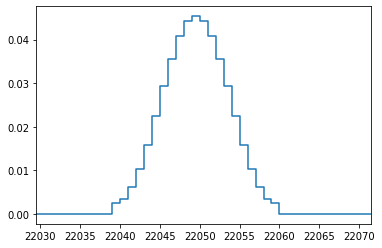

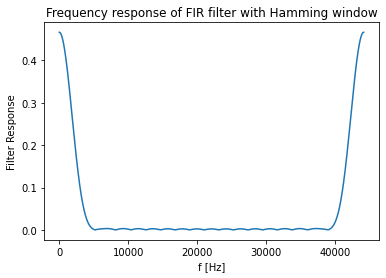

In [232]:
hamming_filter(Hn_21,21)

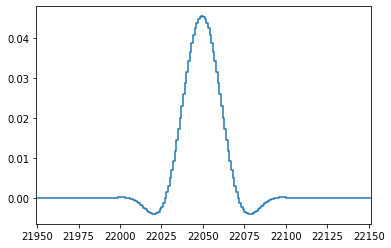

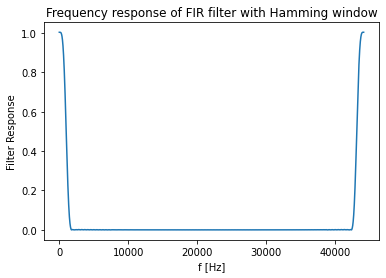

In [233]:
hamming_filter(Hn_101,101)

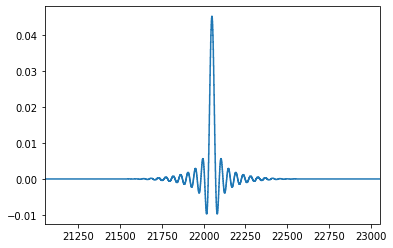

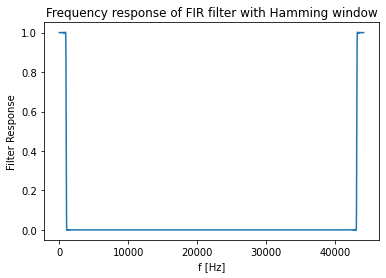

In [234]:
hamming_filter(Hn_1001,1001)

As expected, the frequency response in the cutoff region is much smoother with the Hamming window applied.

<hr/>

## Section 8: A Time-Domain Low-Pass FIR Filter

### Creating a Sample Array

In [235]:
# Generate integer array of samples (i.e. integers from 0 to N where N is the
# total number of datapoints).
n = np.arange(len(raw['t']))

# Offset the array (i.e. from ~ -N/2 to ~ N/2. Hint: find N using the .max()
# notation).
n_centred = n - n.max() / 2

### Creating the Filter Through Convolution

$H_n = 2\frac{f_\mathrm{c}}{f_\mathrm{s}}\mathrm{sinc}
    \left(2\frac{f_\mathrm{c}}{f_\mathrm{s}}n\right)$

In [236]:
# Choose your cut-off frequency
lowpass_time_fc = 1000

# Sampliung frequency
fs = 44100

# Generate the sinc transfer function, using your integer array of samples
# centred about zero, and the cut-off and sampling frequencies. Hint NumPy
# provides a sinc function with np.sinc.
lowpass_time = 2 * lowpass_time_fc / fs * np.sinc(2 * lowpass_time_fc / fs * n_centred)

# Convolve the time-series signal and the sinc filter, using the 'same' option
# to ensure the resulting filtered signal is the same length as the input.
lowpass_time_V = np.convolve(raw['V'], lowpass_time, 'same')

### Plotting the Filter Response (Time Domain)

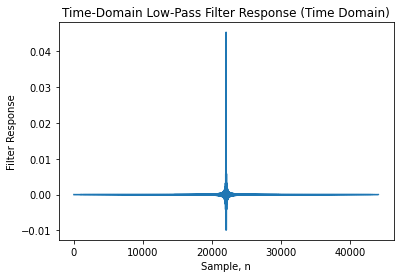

In [237]:
# Plot how the filter appears in the time domain (in terms of samples)
plt.plot(n, lowpass_time)

# Label axes
plt.xlabel('Sample, n')
plt.ylabel('Filter Response')

# Label plot
plt.title('Time-Domain Low-Pass Filter Response (Time Domain)')

# Show plot
plt.show()

### Transforming to the Frequency Domain

In [238]:
# Using an FFT, transform the sinc function to the frequency domain to see its
# effect more clearly.
lowpass_time_freq = np.fft.fft(lowpass_time)

# Using an FFT, transform the filtered signal to the frequency domain
lowpass_time_V_freq_spectrum = np.fft.fft(lowpass_time_V)

### Plotting the Filter Response (Frequency Domain)

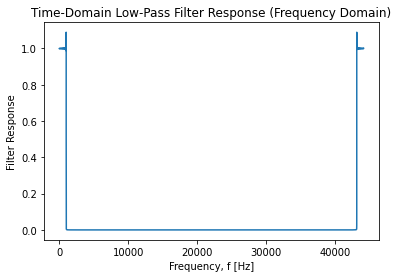

In [239]:
# Plot how the filter affects different frequencies (remember np.abs)
plt.plot(f, np.abs(lowpass_time_freq))

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Filter Response')

# Label plot
plt.title('Time-Domain Low-Pass Filter Response (Frequency Domain)')

# Show plot
plt.show()

### Plotting the Filtered Frequency Spectrum

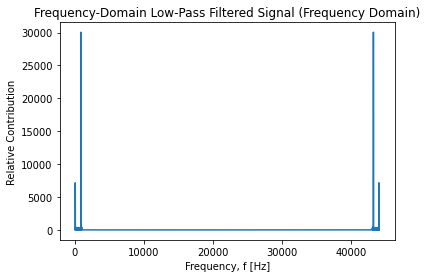

In [240]:
# Plot the filtered frequency spectrum (again, just the magnitude using np.abs)
plt.plot(f, np.abs(lowpass_time_V_freq_spectrum))

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title('Frequency-Domain Low-Pass Filtered Signal (Frequency Domain)')

# Show plot
plt.show()

### Plotting the Filtered Frequency Spectrum: Zoomed

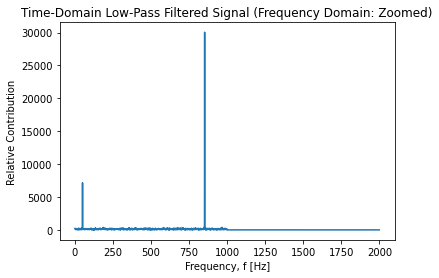

In [242]:
# Plot the same subset of the frequency spectrum as before filtering for good
# comparison.
plt.plot(f[:2000], np.abs(lowpass_time_V_freq_spectrum)[:2000])

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title('Time-Domain Low-Pass Filtered Signal (Frequency Domain: Zoomed)')

# Show plot
plt.show()

### Plotting the Filtered Signal: Zoomed

**Note:** Again, there is no need to plot the full filtered signal, as we know
it won't show the required level of detail we need to see the effects of our
filter. Hence we skip straight to the zoomed plot.

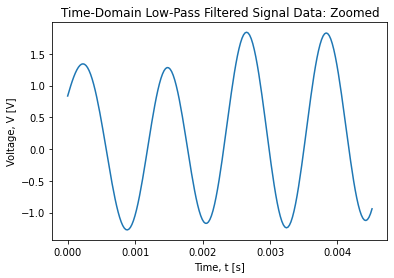

In [243]:
# Plot the same subset of the filtered data as in the first section when we
# viewed a zoomed section of the raw signal.
plt.plot(raw['t'][:200], lowpass_time_V[:200])

# Label axes
plt.xlabel('Time, t [s]')
plt.ylabel('Voltage, V [V]')

# Label plot
plt.title('Time-Domain Low-Pass Filtered Signal Data: Zoomed')

# Show plot
plt.show()

### Listening to the Filtered Signal

In [244]:
display.Audio(lowpass_time_V, rate=fs)

Again, this cleans the signal up nicely, removing high frequency components. However, this now works in the time domain, so is more useful for real-time signal filtering. Note that the 50 Hz AC noise is not removed, so this still causes a level of distortion in the signal.

<hr/>

## Section 9: A Time-Domain High-Pass FIR Filter

### Creating the Filter Through Convolution

$H_n = \delta(n) - 2\frac{f_\mathrm{c}}{f_\mathrm{s}}\mathrm{sinc}
    \left(2\frac{f_\mathrm{c}}{f_\mathrm{s}}n\right)$

In [245]:
# Choose your cut-off frequency
highpass_time_fc = 1400

# Generate a delta-function in the centre of an array (with the same length as
# your number of samples).
highpass_time_delta = np.zeros(n.shape)
highpass_time_delta[int(n.max() / 2)] = 1

# Generate the combination delta and sinc transfer function, using your integer
# array of samples centred about zero, and the cut-off and sampling frequencies.
highpass_time = 2 * lowpass_time_fc / fs * np.sinc(2 * lowpass_time_fc / fs * n_centred)
highpass_time = highpass_time_delta - highpass_time

# As before, convolve the time-series signal and the sinc filter. Remember to
# use the 'same' option to ensure the filtered signal is the same length as the
# original.
highpass_time_V = np.convolve(raw['V'], highpass_time, 'same')

### Plotting the Filter Response (Time Domain)

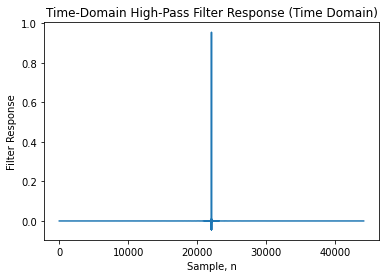

In [246]:
# Plot how the filter appears in the time domain (in terms of samples)
plt.plot(n, highpass_time)

# Label axes
plt.xlabel('Sample, n')
plt.ylabel('Filter Response')

# Label plot
plt.title('Time-Domain High-Pass Filter Response (Time Domain)')

# Show plot
plt.show()

### Transforming to the Frequency Domain

In [247]:
# Using an FFT, transform the sinc function to the frequency domain to see its
# effect more clearly.
highpass_time_freq = np.fft.fft(highpass_time)

# Using an FFT, transform the filtered signal to the frequency domain
highpass_time_V_freq_spectrum = np.fft.fft(highpass_time_V)

### Plotting the Filter Response (Frequency Domain)

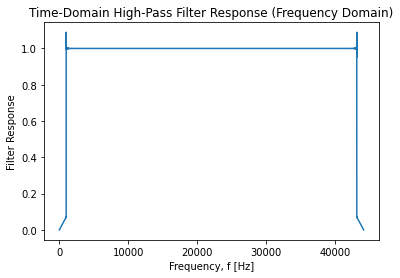

In [248]:
# Plot how the filter affects different frequencies (remember np.abs)
plt.plot(f, np.abs(highpass_time_freq))

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Filter Response')

# Label plot
plt.title('Time-Domain High-Pass Filter Response (Frequency Domain)')

# Show plot
plt.show()

### Plotting the Filtered Frequency Spectrum

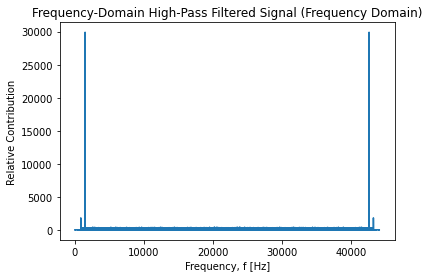

In [249]:
# Plot the filtered frequency spectrum (again, just the magnitude using np.abs)
plt.plot(f, np.abs(highpass_time_V_freq_spectrum))

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title('Frequency-Domain High-Pass Filtered Signal (Frequency Domain)')

# Show plot
plt.show()

### Plotting the Filtered Frequency Spectrum: Zoomed

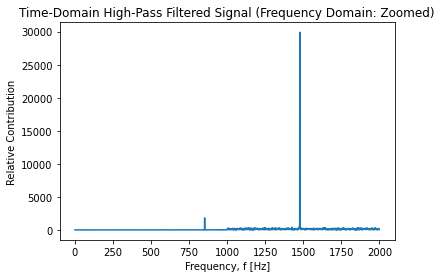

In [250]:
# Plot the same subset of the frequency spectrum as before filtering for good
# comparison.
plt.plot(f[:2000], np.abs(highpass_time_V_freq_spectrum)[:2000])

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title('Time-Domain High-Pass Filtered Signal (Frequency Domain: Zoomed)')

# Show plot
plt.show()

### Plotting the Filtered Signal: Zoomed

**Note:** Again, there is no need to plot the full filtered signal, as we know
it won't show the required level of detail we need to see the effects of our
filter. Hence we skip straight to the zoomed plot.

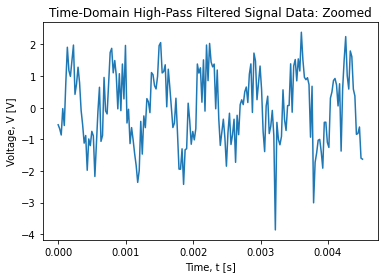

In [251]:
# Plot the same subset of the filtered data as in the first section when we
# viewed a zoomed section of the raw signal.
plt.plot(raw['t'][:200], highpass_time_V[:200])

# Label axes
plt.xlabel('Time, t [s]')
plt.ylabel('Voltage, V [V]')

# Label plot
plt.title('Time-Domain High-Pass Filtered Signal Data: Zoomed')

# Show plot
plt.show()

### Listening to the Filtered Signal

In [252]:
display.Audio(highpass_time_V, rate=fs)

We can clearly hear that the lower frequencies have been largely removed, and the higher frequency remains. However, the response below the cutoff is not perfect; a small peak can still be seen at 852 Hz, and the time domain filter response curve shows some tails at low and high frequencies, so these frequencies are not fully suppressed.

<hr/>

## Section 10: A Time-Domain Band-Pass FIR Filter

### Creating the Filter Through Convolution

$H_n = 2\frac{f_\mathrm{cu}}{f_\mathrm{s}}\mathrm{sinc}
    \left(2\frac{f_\mathrm{cu}}{f_\mathrm{s}}n\right) -
    2\frac{f_\mathrm{cl}}{f_\mathrm{s}}\mathrm{sinc}
    \left(2\frac{f_\mathrm{cl}}{f_\mathrm{s}}n\right)$

In [254]:
# Choose your cut-off frequencies
bandpass_time_fc_low = 800
bandpass_time_fc_upp = 900

# Generate the first sinc term, using your integer array of samples centred
# about zero, and the cut-off and sampling frequencies.
bandpass_time_upp = 2 * bandpass_time_fc_upp / fs * np.sinc(
    2 * bandpass_time_fc_upp / fs * n_centred
)

# Generate the second sinc term, using your integer array of samples centred
# about zero, and the cut-off and sampling frequencies.
bandpass_time_low = 2 * bandpass_time_fc_low / fs * np.sinc(
    2 * bandpass_time_fc_low / fs * n_centred
)

# Combine the two sinc functions to create the final time-domain transfer
# function.
bandpass_time = bandpass_time_upp-bandpass_time_low

# As before, convolve the time-series signal and the sinc filter. Remember to
# use the 'same' option to ensure the filtered signal is the same length as the
# original.
bandpass_time_V = np.convolve(raw['V'], bandpass_time, 'same')

### Plotting the Filter Response (Time Domain)

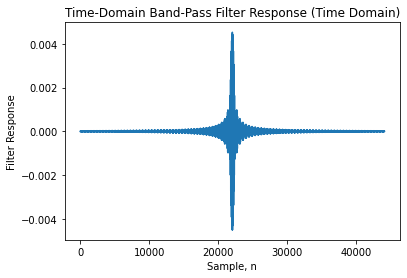

In [255]:
# Plot how the filter appears in the time domain (in terms of samples)
plt.plot(n, bandpass_time)

# Label axes
plt.xlabel('Sample, n')
plt.ylabel('Filter Response')

# Label plot
plt.title('Time-Domain Band-Pass Filter Response (Time Domain)')

# Show plot
plt.show()

### Transforming to the Frequency Domain

In [256]:
# Using an FFT, transform the sinc function to the frequency domain to see its
# effect more clearly.
bandpass_time_freq = np.fft.fft(bandpass_time)

# Using an FFT, transform the filtered signal to the frequency domain
bandpass_time_V_freq_spectrum = np.fft.fft(bandpass_time_V)

### Plotting the Filter Response (Frequency Domain)

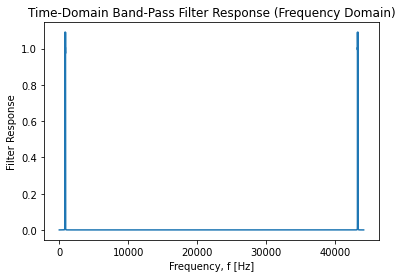

In [257]:
# Plot how the filter affects different frequencies (remember np.abs)
plt.plot(f, np.abs(bandpass_time_freq))

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Filter Response')

# Label plot
plt.title('Time-Domain Band-Pass Filter Response (Frequency Domain)')

# Show plot
plt.show()

### Plotting the Filtered Frequency Spectrum

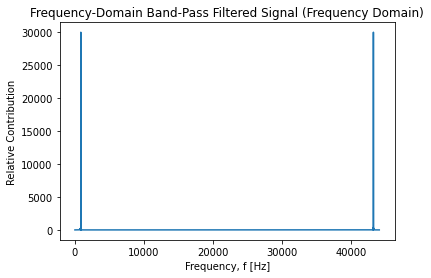

In [258]:
# Plot the filtered frequency spectrum (again, just the magnitude using np.abs)
plt.plot(f, np.abs(bandpass_time_V_freq_spectrum))

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title('Frequency-Domain Band-Pass Filtered Signal (Frequency Domain)')

# Show plot
plt.show()

### Plotting the Filtered Frequency Spectrum: Zoomed

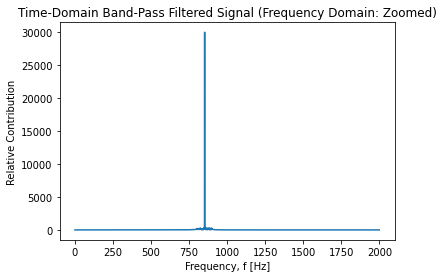

In [259]:
# Plot the same subset of the frequency spectrum as before filtering for good
# comparison.
plt.plot(f[:2000], np.abs(bandpass_time_V_freq_spectrum)[:2000])

# Label axes
plt.xlabel('Frequency, f [Hz]')
plt.ylabel('Relative Contribution')

# Label plot
plt.title('Time-Domain Band-Pass Filtered Signal (Frequency Domain: Zoomed)')

# Show plot
plt.show()

### Plotting the Filtered Signal: Zoomed

**Note:** Again, there is no need to plot the full filtered signal, as we know
it won't show the required level of detail we need to see the effects of our
filter. Hence we skip straight to the zoomed plot.

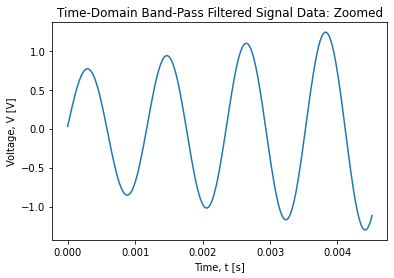

In [260]:
# Plot the same subset of the filtered data as in the first section when we
# viewed a zoomed section of the raw signal.
plt.plot(raw['t'][:200], bandpass_time_V[:200])

# Label axes
plt.xlabel('Time, t [s]')
plt.ylabel('Voltage, V [V]')

# Label plot
plt.title('Time-Domain Band-Pass Filtered Signal Data: Zoomed')

# Show plot
plt.show()

### Listening to the Filtered Signal

In [261]:
display.Audio(bandpass_time_V, rate=fs)

The effect of the filter is clear to hear: we get a pure sine wave tone, with little to no audible noise. This is confirmed by the pure sine wave form of the plot.

<hr/>

## Section 11: FIR filter in the time domain

### Create the input signal

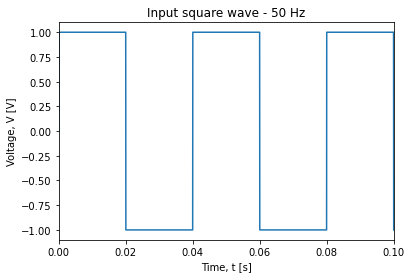

In [263]:
# sampling frequency
fsampling = 44100
# signal frequency
fsignal = 50
# number of samples in signal
nsamples = 44100

squaresignal = [0]*nsamples
for i in range(1,nsamples):
    if int(i/(fsampling/fsignal))%2==0:
        # fsampling/fsignal is the number of samples per period
        # if i divided by this is even, then the signal is positive
        squaresignal[i] = 1
    else:
        squaresignal[i] = -1

time = np.arange(0,1,1/fsampling)
plt.plot(time,squaresignal)
plt.xlabel('Time, t [s]')
plt.ylabel('Voltage, V [V]')
plt.title('Input square wave - 50 Hz')
plt.xlim([0,0.1])
plt.show()

### Create and apply the filter

In [264]:
# Choose your cut-off frequency
lowpass_time_fc = 1000

n = np.arange(len(squaresignal))
# Offset the array (i.e. from ~ -N/2 to ~ N/2. Hint: find N using the .max()
# notation).
n_centred = n - (n.max()+1) / 2

# Generate the sinc transfer function, using your integer array of samples
# centred about zero, and the cut-off and sampling frequencies. Hint NumPy
# provides a sinc function with np.sinc.
lowpass = 2 * lowpass_time_fc / fsampling * np.sinc(2 * lowpass_time_fc / fsampling * n_centred)

# Convolve the time-series signal and the sinc filter, using the 'same' option
# to ensure the resulting filtered signal is the same length as the input.
square_filtered = np.convolve(squaresignal, lowpass, 'same')

### Plot input and output signal

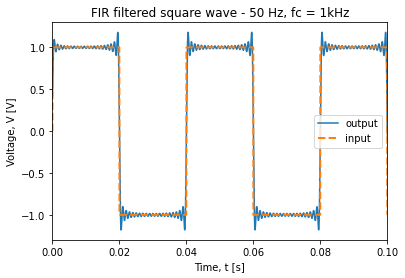

In [273]:
plt.plot(time,square_filtered,label="output")
plt.plot(time,squaresignal,label="input", linestyle='--', linewidth=2)
plt.xlabel('Time, t [s]')
plt.ylabel('Voltage, V [V]')
plt.title('FIR filtered square wave - 50 Hz, fc = 1kHz')
plt.legend(loc="right")
plt.xlim([0,0.1])
plt.show()

### Check phase response of filter

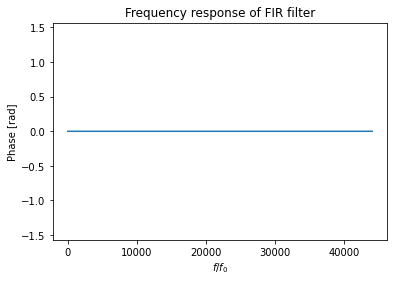

In [275]:
# FFT of impulse reponse
freq_spectrum = np.fft.fft(lowpass)

# is there a phase introduced by the filter?
phase = np.angle(freq_spectrum)
# shift phase so that output is only in the range -pi/2 to pi/2
for i,x in enumerate(phase):
    if x > np.pi/2:
        phase[i] = x - np.pi
    elif x < -np.pi/2:
        phase[i] = x + np.pi

# plot phase 
freq = np.arange(0,fsampling,fsampling/nsamples)
plt.plot(freq,phase)
plt.ylim([-np.pi/2,np.pi/2])
# Label axes
plt.xlabel(r'$f/f_{0}$')
plt.ylabel('Phase [rad]')
# Label plot
plt.title('Frequency response of FIR filter')
# Show plot
plt.show()

The response of this filter is similar, albeit slightly different to the active one in section 2.3. Notable differences are:

- This filter does not have to obey causality, and so the oscillations at each peak/trough are symmetrical
- There is negligible ramp-up time, since the filter can "anticipate" the signal pulse (again, a causality difference)